This script takes formats the output of our Biosemi device into something friendlier to use. Our Biosemi device can only send triggers ranging from 0-255 (8 bit). We had to resort to sending two triggers to properly describe image IDs. This script groups up these 2 triggers to a single one, and also deletes phantom triggers that get sent by the device for some reason. Then we export the EEG data into an .fif format for MNE preprocessing later.

In [10]:
# Script from steps 1-7
import mne
import pandas as pd
import os
import numpy as np
import csv

In [11]:
DATA_PATH = "/srv/eeg_reconstruction/shared/biosemi-dataset"
bdf_file = 'subj04_session2'

bdf_file_path = os.path.join(DATA_PATH, 'bdf', f"{bdf_file}.bdf") 

# Read the BDF file
raw = mne.io.read_raw_bdf(bdf_file_path, preload=True)
# fiff_file = 'subj03_session1'
# fiff_file_path = 'subj03_session1.fif'
# raw = mne.io.read_raw_fif(fiff_file, preload=True)
print("Channels:", raw.ch_names)

Extracting EDF parameters from /srv/eeg_reconstruction/shared/biosemi-dataset/bdf/subj04_session2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1784319  =      0.000 ...  3484.998 secs...
Channels: ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']


Creating RawArray with float64 data, n_channels=2, n_times=1784320
    Range : 0 ... 1784319 =      0.000 ...  3484.998 secs
Ready.


/tmp/ipykernel_111103/3506950687.py:6: RuntimeWarning: Less than 2 channels in group "trigger" when combining by method "functools.partial(<function mean at 0x7fd5000d45b0>, axis=0)".
  elec_avg_epochs = mne.channels.combine_channels(raw, {'occipital': [i for i in occ_inds], 'trigger': [status_ind]}, method = 'mean')


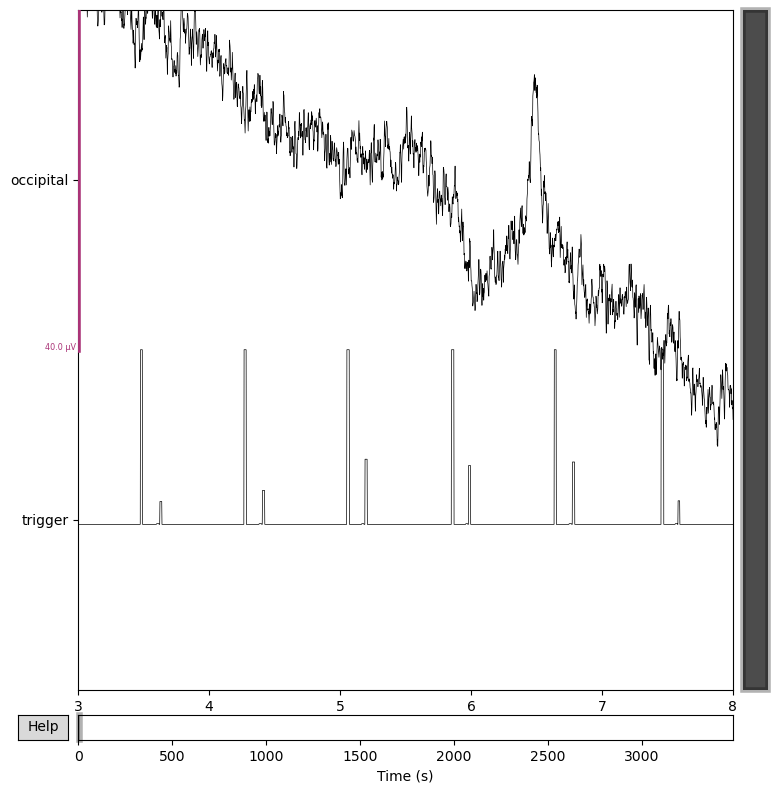

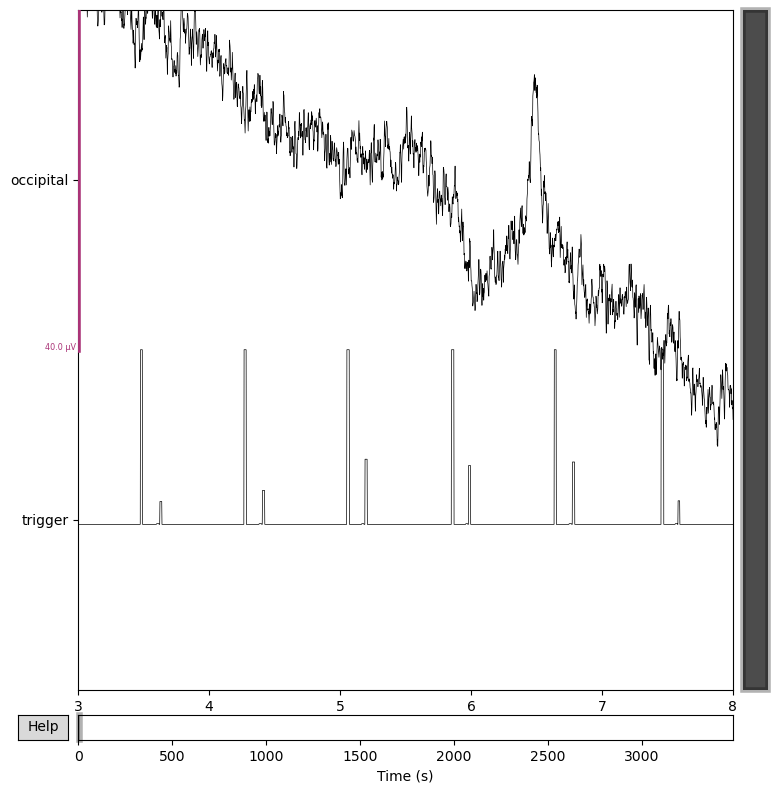

In [9]:
occ_elecs = [ch for ch in raw.ch_names if ('o' in ch.lower() or 'p' in ch.lower()) and not 'c' in ch.lower()]
occ_inds = [raw.ch_names.index(elec) for elec in occ_elecs]
status_ind = raw.ch_names.index('Status')

# Averaging epochs over occipital electrodes
elec_avg_epochs = mne.channels.combine_channels(raw, {'occipital': [i for i in occ_inds], 'trigger': [status_ind]}, method = 'mean')
elec_avg_epochs.plot(start=3, duration=5)

In [12]:
events = mne.find_events(raw, stim_channel='Status', shortest_event=1)
print("events.shape:", events.shape)
print("events[:10]:", events[:10])
print("events[-10:]:", events[-10:])

Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
12719 events found on stim channel Status
Event IDs: [    1     2     3     4     5     6     7     8     9    10    11    12
    13    14    15    16    17    18    19    20    21    22    23    24
    25    26    27    28    29    30    31    32    33    34    35    36
    37    38    39    40    41    42    43    44    45    46    47    48
    49    50    51    52    53    54    55    56    57    58    59    60
    61    62    63    64    65    66    67    68    69    70    71    72
    73    74    75    76    77    78    79    80    81    82    83    84
    85    86    87    88    89    90    91    92    93    94    95    96
    97    98    99   100   101   102   103   104   105   106   107   108
   109   110   111   112   113   114   115   116   117   118   119   120
   151   152   153   154   155   156   157   158   159   160   161   162
   163   164   1

In [14]:
unique_event_ids = np.unique(events[:, 2])  # Extract unique event IDs
print(unique_event_ids)

# Special codes
# 1. **198:** start
# 2. **199:** stop
# 3. **201:** train block
# 4. **202-217:** testing blocks
# 5. **START_RECORD = 198; % the trigger to start the EEG recording**
# 6. **STOP_RECORD = 199; % the trigger to stop the EEG recording**

# First trigger
# 1-16: block number
# 151-166: block number + 150 to specify oddball

# Second trigger
# 1-120: Image ID within the block

# Third trigger
# CORRECT_HIT = 254; % the trigger that records a correct hit to a catch stimulus
# FALSE_ALARM = 253; % the trigger that records a false hit to an experimental stimulus
# CORRECT_REJ = 252; % the trigger that records a correct no-key to an experiment stimulus
# MISS = 251; % the trigger that records a false no-key to a catch stimulus

[    1     2     3     4     5     6     7     8     9    10    11    12
    13    14    15    16    17    18    19    20    21    22    23    24
    25    26    27    28    29    30    31    32    33    34    35    36
    37    38    39    40    41    42    43    44    45    46    47    48
    49    50    51    52    53    54    55    56    57    58    59    60
    61    62    63    64    65    66    67    68    69    70    71    72
    73    74    75    76    77    78    79    80    81    82    83    84
    85    86    87    88    89    90    91    92    93    94    95    96
    97    98    99   100   101   102   103   104   105   106   107   108
   109   110   111   112   113   114   115   116   117   118   119   120
   151   152   153   154   155   156   157   158   159   160   161   162
   163   164   165   166   201   202   203   204   205   206   207   208
   209   210   211   212   213   214   215   216   251   252   253   254
 65536 65734]


In [5]:
# Output our events into a .csv file
csv_file_path = os.path.join('raw_csv', f"{bdf_file}.csv") 
os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row
    writer.writerow(['onset', 'sig', 'code'])
    
    # Write the data rows
    for event in events:
        writer.writerow(event)

The cell below consolidates the triplet event codes in the raw_csv file in a single event code in the parsed_csv file. Oddballs are ignored. If an error is outputted, the raw csv file likely has a phantom event code, and will require manual inspection to remove it.

In [6]:
def create_new_row(row, img_idx):
    new_row = row.copy()
    new_row.iloc[2] = img_idx

    return new_row

# csv_file_path = "/srv/eeg_reconstruction/jonathan/alljoined_preprocessing/raw_csv/subj08_session2.csv"
raw_eeg_df = pd.read_csv(csv_file_path)
new_df = pd.DataFrame(columns=raw_eeg_df.columns)

i = 2
block_number = 1
block_trigger_offset = 150
error_count = 0

while i < raw_eeg_df.shape[0] - 2:
    
    # New block, increment block number and add a block code to new csv
    if raw_eeg_df.iloc[i, 2] == 65536:
        block_number += 1
        i+=3
        
    first_row_event_code = raw_eeg_df.iloc[i, 2]
    second_row_event_code = raw_eeg_df.iloc[i+1, 2]
    third_row_event_code = raw_eeg_df.iloc[i+2, 2]

   #  We use this for the old trigger script, for sessions 4 and lower.
    # if first_row_event_code > 100:
    #     second_row_event_code -= 100
    #     first_row_event_code += 50

    # 254 - Oddball - Correct - hit 
    if third_row_event_code == 254 and first_row_event_code == block_number+block_trigger_offset:
        pass 
    
    # # 251 - Oddball - Miss - no hit
    elif third_row_event_code == 251 and first_row_event_code == block_number+block_trigger_offset:
        pass
        
    # 252 - Correct - no hit  
    elif third_row_event_code == 252 and first_row_event_code == block_number:
        img_idx = ((block_number - 1) % 8) * 120 + second_row_event_code
        modified_row = create_new_row(raw_eeg_df.iloc[i], img_idx)
        new_df = new_df._append(modified_row, ignore_index=True)
        
    # 253 - False hit 
    elif third_row_event_code == 253 and first_row_event_code == block_number:
        img_idx = ((block_number - 1) % 8) * 120 + second_row_event_code
        modified_row = create_new_row(raw_eeg_df.iloc[i], img_idx)
        new_df = new_df._append(modified_row, ignore_index=True)

    else:
        if error_count < 10:
            error_count += 1
            print(f'Error in line {i+2}:', first_row_event_code, third_row_event_code)

    # Jump 3 rows for next trial
    i += 3

# Save data
final_output_path = os.path.join('parsed_csv', f"{bdf_file}.csv") 
os.makedirs(os.path.dirname(final_output_path), exist_ok=True)
new_df.to_csv(final_output_path, index=False)
print('Saved to: ', final_output_path)

Saved to:  parsed_csv/subj08_session2.csv


In [15]:
# Confirm that all images appear 4 times
# Step 1: Load the CSV file
final_output_path = "parsed_csv/subj08_session2.csv" # for testing
events_df = pd.read_csv(final_output_path)


code_counts = events_df.groupby('code').size()
codes_less = code_counts[code_counts < 4].index.tolist()
codes_more = code_counts[code_counts > 4].index.tolist()

print("Stimuli that appear less than 4 times:", codes_less)
print("Stimuli that appear more than 4 times:", codes_more)

Stimuli that appear less than 4 times: [471, 883, 940]
Stimuli that appear more than 4 times: []


In [16]:
parsed_eeg_df = pd.read_csv(final_output_path)

# Count the number of trials
num_trials = parsed_eeg_df.shape[0]
print("Number of trials:", num_trials)

# Count the number of repetitions for each unique image
image_counts = parsed_eeg_df['code'].value_counts()
print("Number of repetitions for unique images:")
print(image_counts.value_counts())

Number of trials: 3837
Number of repetitions for unique images:
count
4    957
3      3
Name: count, dtype: int64


In [20]:
# Prepare the events array required by MNE
events_array = events_df[['onset', 'sig', 'code']].to_numpy()

# Step 2: Load the BDF file
raw = mne.io.read_raw_bdf(bdf_file_path, preload=True)

# Step 3 & 4: Override events
# This example assumes you want to replace all existing events
raw.add_events(events_array, stim_channel='Status', replace=True)

# Step 5: Save the modified BDF file
# Note: MNE does not support saving in BDF format directly, so consider saving in a different format or use a different library for BDF writing
fif_path = os.path.join(DATA_PATH, 'fif', f"{bdf_file}_eeg.fif") 
os.makedirs(os.path.dirname(fif_path), exist_ok=True)
raw.save(fif_path, overwrite=True)

# Step 6: Check the new BDF file
raw_fif = mne.io.read_raw_fif(fif_path)
events = mne.find_events(raw_fif)
print("events.shape:", events.shape)

Extracting EDF parameters from /srv/eeg_reconstruction/shared/biosemi-dataset/bdf/subj04_session2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1784319  =      0.000 ...  3484.998 secs...
Overwriting existing file.
Writing /srv/eeg_reconstruction/shared/biosemi-dataset/fif/subj04_session2_eeg.fif
Closing /srv/eeg_reconstruction/shared/biosemi-dataset/fif/subj04_session2_eeg.fif
[done]
Opening raw data file /srv/eeg_reconstruction/shared/biosemi-dataset/fif/subj04_session2_eeg.fif...
Isotrak not found
    Range : 0 ... 1784319 =      0.000 ...  3484.998 secs
Ready.
3837 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  7